In [1]:
import pandas as pd
import numpy as np
import re
import pylab as plt
import copy
import math

StataDct code from Think Stats, as exercise in chapter 13, examined survival curve of divorce in marriage from a different cycle of NSFG survey

In [2]:
def ReadStataDct(dct_file,filename):
    """Reads a Stata dictionary file.

    dct_file: string filename
    options: dict of options passed to open()

    returns: FixedWidthVariables object
    
    FROM Think Stats (A. Downey)
    """
    type_map = dict(byte=int, int=int, long=int, float=float, double=float)

    var_info = []
    for line in open(dct_file):
        match = re.search( r'_column\(([^)]*)\)', line)
        if match:
            start = int(match.group(1))
            t = line.split()
            vtype, name, fstring = t[1:4]
            name = name.lower()
            if vtype.startswith('str'):
                vtype = str
            else:
                vtype = type_map[vtype]
            long_desc = ' '.join(t[4:]).strip('"')
            var_info.append((start, vtype, name, fstring, long_desc))
            
    columns = ['start', 'type', 'name', 'fstring', 'desc']
    variables = pd.DataFrame(var_info, columns=columns)

    # fill in the end column by shifting the start column
    variables['end'] = variables.start.shift(-1)
    variables.loc[len(variables)-1, 'end'] = 0

    #dct = FixedWidthVariables(variables, index_base=1)
    colspecs = variables[['start', 'end']] - 1
    colspecs = colspecs.astype(np.int).values.tolist()
    names = variables['name']
    df = pd.read_fwf(filename,colspecs=colspecs,names=names)
    return df

In [3]:
df=ReadStataDct('2006_2010_FemRespSetup.dct','2006_2010_FemResp.dat')

In [4]:
def addMYdate_len(df):
    df['intvMY'] = (df.cmintvw - 1278.0)/12.0 + 2006.5
    df['cmarMY'] = (df.cmmarrch - 1278.0)/12.0 + 2006.5
    
    # for on going marriages, get length of marriage, so far, at time of interview
    df['sofarLen'] = df.intvMY - df.cmarMY
    tmpLen = df.sofarLen
    tmpLen[tmpLen < 0] = 0
    
    for i in range(6):
        if i > 0:
            col_name = ['whmarhx_y'+str(i+1),'whmarhx_m'+str(i+1),'divdathx_y'+str(i+1),'divdathx_m'+str(i+1)]
        else:
            col_name = ['whmarhx_y','whmarhx_m','divdathx_y','divdathx_m']
        tmp_month = copy.deepcopy(df[col_name[1]])
        
        # some months are encoded as > 12. 13, 14, 15, and 16 mean winter, fall, spring, and summer
        # I take the middle month then as the month (will introduce some error)
        # 98 and 99 means refused to answer or did not know, I take middle of year as guess
        # once again this will introduce some error for those few affected
        tmp_month[tmp_month == 13] = 1.0
        tmp_month[tmp_month == 14] = 4.0
        tmp_month[tmp_month == 15] = 7.0
        tmp_month[tmp_month == 16] = 10.0
        tmp_month[(tmp_month == 98) | (tmp_month == 99)] = 6.0
        df['marMY'+str(i+1)] = df[col_name[0]] + tmp_month/12.0
        
        tmp_month = copy.deepcopy(df[col_name[3]])
        tmp_month[tmp_month == 13] = 1.0
        tmp_month[tmp_month == 14] = 4.0
        tmp_month[tmp_month == 15] = 7.0
        tmp_month[tmp_month == 16] = 10.0
        tmp_month[(tmp_month == 98) | (tmp_month == 99)] = 6.0
        df['divMY'+str(i+1)] = df[col_name[2]] + tmp_month/12.0
        
        # due to some of my guessing on month, the resulting marriage length
        # calculated will be < 0 if people got married and divorced (or annuled)
        # within the same year (or got the year wrong)
        # and when people do not know the year or refuse to answer, it gets coded
        # as 98 and 99, resutling in large, positive, or negative marriage lengths
        # for the few affected, I force marriage length to be 0 (ie married and divorced the same year)
        tmp_marLen = df['divMY'+str(i+1)] - df['marMY'+str(i+1)]
        tmp_marLen[(tmp_marLen < 0) | (tmp_marLen > 1e2)] = 0
        df['marLen'+str(i+1)] = tmp_marLen

addMYdate_len(df)

/anaconda3/envs/condasc/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [5]:
# from now on, treat all divorces the same
# let's get length of marriages, that end in divorce and are on going, into two arrays
def divMarArray(df):
    all_mlen = np.array(df.marLen1.dropna())
    all_mwei = np.array(df[df.marLen1>=0].wgtq1q16)
    for i in range(5):
        tmp_array = np.array(df['marLen'+str(i+2)].dropna())
        all_mlen = np.append(all_mlen,tmp_array)
        tmp_array = np.array(df[df['marLen'+str(i+2)]>=0].wgtq1q16)
        all_mwei = np.append(all_mwei,tmp_array)
    
    sf_len = np.array(df.sofarLen.dropna())
    sf_wei = np.array(df[df.sofarLen>=0].wgtq1q16)
    return all_mlen, all_mwei, sf_len, sf_wei
mlen, mwei, sflen, sfwei = divMarArray(df)

In [6]:
def estDiv(d_arr,d_wei,sm_arr,sm_wei,dyr=1.0):
    years = np.array(range(int(np.max(d_arr)/dyr + 1.0)))*dyr
    est_d = np.zeros(len(years)-1)
    est_m = np.zeros(len(years)-1)
    esd_len = np.zeros(len(years)-1)
    esm_len = np.zeros(len(years)-1)
    rate_d = np.zeros(len(years)-1)
    div_w = np.zeros(len(years)-1)
    known_d = np.zeros(len(years)-1)
    d_error = np.zeros(len(years)-1)
    
    
    for i in range(len(years)-1):
        dm_tot = float(len(np.where(d_arr >= years[i])[0]) + len(np.where(sm_arr >= years[i])[0]))
        tot_w = np.sum(d_wei[d_arr >= years[i]]) + np.sum(sm_wei[sm_arr >= years[i]])
        
        known_d[i] = float(len(np.where((d_arr >= years[i]) & (d_arr < years[i+1]))[0]))
        div_w[i] = np.sum(d_wei[(d_arr >= years[i]) & (d_arr < years[i+1])])
        
        dm_ukn = float(len(np.where((sm_arr >= years[i]) & (sm_arr < years[i+1]))[0]))
        ukn_w = np.sum(sm_wei[(sm_arr >= years[i]) & (sm_arr < years[i+1])])
        if i > 0:
            dm_ukn += esm_len[i-1]
            dm_tot += esm_len[i-1]
            tot_w += est_m[i-1]
            ukn_w += est_m[i-1]
        
        rate_d[i] = div_w[i] / (tot_w - ukn_w)
        
        est_d[i] = rate_d[i] * ukn_w
        
        est_m[i] = (1.0 - rate_d[i]) * ukn_w
        esm_len[i] = (1.0 - rate_d[i]) * dm_ukn
        
        d_error[i] = known_d[i]**2*dm_tot**2*dm_ukn/(dm_tot - dm_ukn)**4 + dm_ukn**2*known_d[i]/(dm_tot - dm_ukn)**2
        d_error[i] += dm_ukn**2*known_d[i]**2*dm_tot/(dm_tot - dm_ukn)**4

    d_error = np.sqrt(d_error)
    cumu_d = np.array([np.sum(div_w[:i+1])+np.sum(est_d[:i+1]) for i in range(len(est_d))])
    cumu_e = np.array([math.sqrt(np.sum(d_error[:i+1]**2) + np.sum(known_d[:i+1])) for i in range(len(est_d))])
    
    return rate_d,years[1:],cumu_d,d_error,cumu_e, div_w+est_d

Function to create each cycle of mock data

1) create mock sample w/ same size as real sample

2) based on the input real divorce rate, randomly assign entries to either stay married or end in divorce

3) for those ending in divorce, randomly draw marriage length (before divorce) from real data
    - then, randomly draw time of participation in study from real data
    - compare the two, if the interview happens before the divorce, they will still be measured as married
    
4) for those who are measured to be divorce, return their marriage length before divorce

5) for those who will divorce after the study, return their marriage length so far

6) for those who will remain married, randomly draw marriage length at time of study participation (from real data)
    - add this to the array from step 5)

In [19]:
def createMock(d_len, d_wei, m_len, m_wei, real_dr=0.5):
    all_tot = len(d_len)+len(m_len)
    
    div_sim = np.random.random(all_tot)
    
    num_div = len(div_sim[div_sim < real_dr])
    num_mar = all_tot - num_div
    
    len_div = np.random.choice(d_len,num_div,p=d_wei/np.sum(d_wei),replace=True)
    len_itv = np.random.choice(m_len,num_div,p=m_wei/np.sum(m_wei),replace=True)
    
    len_diff = len_div - len_itv
    
    return_div = len_div[len_diff <= 0]
    
    len_mar = np.random.choice(m_len,num_mar,p=m_wei/np.sum(m_wei),replace=True)
    return_mar = len_itv[len_diff > 0]
    return_mar = np.append(len_mar,return_mar)
    
    return return_div, return_mar

do this for a set number of iterations

Print the fraction of iterations where the calculated divorce rate is <= 0.452 (the final divorce rate at 27 yrs found from the real data). Also print the fraction of iterations which are consistent with the input real divorce rate

In [68]:
def runMock(d_len, d_wei, m_len, m_wei, real_dr=0.5,numt=10000,idB=-1):
    num_p = 0
    num_c = 0
    mock_dr = np.zeros(numt)
    mock_er = np.zeros(numt)
    
    for i in range(numt):
        mock_div, mock_mar = createMock(d_len, d_wei, m_len, m_wei, real_dr=real_dr)
        mock_dw = np.zeros(len(mock_div))+1.0
        mock_mw = np.zeros(len(mock_mar))+1.0
        mock_rate,yrs,mock_cumud,mock_d_error,mock_cumue,mock_tot_d = estDiv(mock_div,mock_dw,mock_mar,mock_mw)
        
        mock_dr[i] = round(mock_cumud[idB]/(np.sum(mock_dw)+np.sum(mock_mw)),3)
        mock_er[i] = round(mock_cumue[idB]/(len(mwei)+len(sfwei)),3)
        if mock_dr[i] <= 0.452:
            num_p += 1.0
        if (mock_dr[i] - mock_er[i] <= real_dr) & (mock_dr[i] + mock_er[i] >= real_dr):
            num_c += 1.0
            
    print ('Frac w/ divorce rate <= 0.452: '+str(num_p/numt))
    print ('Frac consistent w/ DR = '+str(real_dr)+': '+str(num_c/numt))
    return mock_dr, mock_er

In [63]:
mock_dr, mock_er = runMock(mlen, mwei, sflen, sfwei)

Frac w/ divorce rate <= 0.452: 0
Frac consistent w/ DR = 0.5 : 0.3191


The result found from the real data is significant

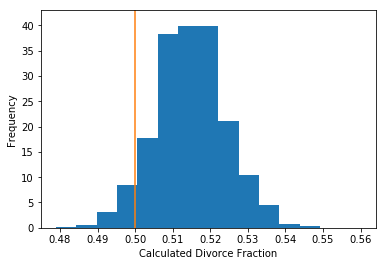

In [64]:
hist,bins,junk = plt.hist(mock_dr,bins=15,normed=1)
plt.plot([0.5,0.5],[0,np.max(hist)+3])
plt.ylim([0,np.max(hist)+3])
plt.xlabel('Calculated Divorce Fraction')
plt.ylabel('Frequency')

As previously suspected from the analysis of the real data, final divorce fractions from mock data are generally over-estimates of the true value (shown here with the vertical line)

Perhaps this will change if divorce rate is calculated at earlier times

In [65]:
junk, _ = runMock(mlen, mwei, sflen, sfwei,idB=15)

Frac w/ divorce rate <= 0.452: 0
Frac consistent w/ DR = 0.5 : 0.7041


In [66]:
junk, _ = runMock(mlen, mwei, sflen, sfwei,idB=-2)

Frac w/ divorce rate <= 0.452: 0
Frac consistent w/ DR = 0.5 : 0.4043


And what about the final result I previously reported (40.7% at 21 years)

In [69]:
mock_dr_p, mock_er_p = runMock(mlen, mwei, sflen, sfwei,real_dr=0.407)

Frac w/ divorce rate <= 0.452: 0.9999
Frac consistent w/ DR = 0.407: 0.3389


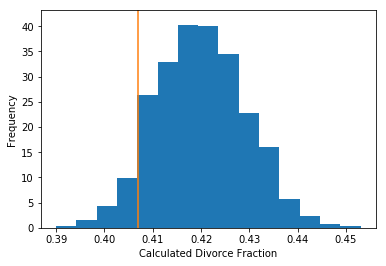

In [72]:
hist,bins,junk = plt.hist(mock_dr_p,bins=15,normed=1)
plt.plot([0.407,0.407],[0,np.max(hist)+3])
plt.ylim([0,np.max(hist)+3])
plt.xlabel('Calculated Divorce Fraction')
plt.ylabel('Frequency')